Importing the basic libraries for signal processing and other data related operation.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy
import pandas as pd


This cell is for initializing the ecg data. Sampling Frequency used here is 1024sps and inbuilt detrend function is used to remove the baseline wander from the data.

In [2]:
#initialize the ecg data and sampling rate,  sampling_axis in terms of samples and linearly detrend the signal
ecg = pd.read_csv('ecg.csv')
srate = 1024
data = np.array(ecg.iloc[:,0])
data = np.transpose(data)
sample_axis = np.arange(1,len(data)+1)
n = len(data)
new_data = scipy.signal.detrend(data)


Design of a butterworth bandpass filter with cutoff frequency 3Hz-40Hz as this frequency correspond to QRS complex in an ECG signal. Filter design is being evaluated just to make sure that design specification matches the ideal filter design.

<IPython.core.display.Javascript object>


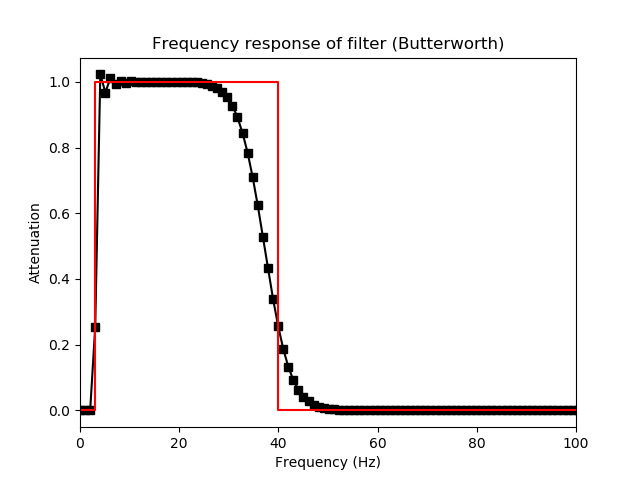

In [3]:
#Develop a butterworth bandpass filter of cutoff frequency 3Hz and 40Hz and evaluation of filter kernal by using the filter 
# in filtering the impulse response
nyquist = srate/2
frange = [3,40]

fkernB,fkernA = scipy.signal.butter(5,np.array(frange)/nyquist,btype = 'bandpass')

filtpow = np.abs(scipy.fftpack.fft(fkernB))**2

hz = np.linspace(0,nyquist,int(np.floor(len(fkernB)/2)+1))

impres = np.zeros(1001)
impres[501] = 1

fimp = scipy.signal.filtfilt(fkernB,fkernA,impres,axis= -1)

fimpX = np.abs(scipy.fftpack.fft(fimp))**2
hz = np.linspace(0,nyquist,int(np.floor(len(impres)/2)+1))


plt.plot(hz,fimpX[0:len(hz)],'ks-')
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'r')
plt.xlim([0,100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation')
plt.title('Frequency response of filter (Butterworth)')
plt.show()


Removing first 400 sample to compensate the edge effect and then a time domain smmothning filter is applied.

In [5]:
# filter the detrended signal using the above signal.
filter_signal = scipy.signal.filtfilt(fkernB,fkernA,new_data)
#Adjusting the fitered data to compensate the edge effect at the starting by removing the first 400 samples.
filter_signal = filter_signal[400:]
smooth_signal = scipy.signal.savgol_filter(filter_signal,23,12)


Creat a window of 5min means 300*srate number of samples for the peak detection. This window is a movable window controlled by the variable st_pt means starting point. User can choose the st_pt and then a window of length 300*srate number of samples will be available for analysis. Peak detection inbuilt function is used to detect peaks and plotting is done.

<IPython.core.display.Javascript object>


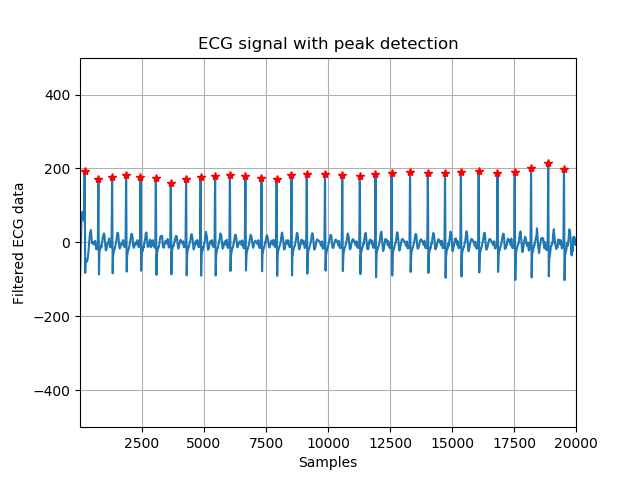

In [6]:
#Dividing the filtered signal in 5 min window which means samples = 300*srate. Variable st_pt is starting point of the window.
#Changing st_pt different windows of filtered signal can be obtained, each window contains 300*srate number of samples.
st_pt = 0
sample_win = 300*srate
smooth_signal = smooth_signal[st_pt : st_pt+sample_win]

# peak detection of a window and plotting.

pos_pks,_ = scipy.signal.find_peaks(smooth_signal,height = [150,220],distance = 524)
plt.figure(2)
plt.plot(sample_axis[st_pt:st_pt+sample_win],smooth_signal)
plt.plot(pos_pks,smooth_signal[pos_pks],'r*')
plt.xlim([1,20000])
plt.ylim([-500,500])
plt.title("ECG signal with peak detection")
plt.xlabel("Samples")
plt.ylabel("Filtered ECG data")
plt.grid(True)
plt.show()





Difference between the postion of two adjacent peaks are calculated and this difference is converted into the units of time by dividing with sampling frequency.

In [8]:
#finding the duration between peaks in terms of samples
pos_locs = np.diff(pos_pks)

#calculation of duration between the peaks in terms of seconds.

time_duration  = pos_locs/srate

Calculation of heart rate by using the formula HR = 60/RR interval in sec is done and plotted.

<IPython.core.display.Javascript object>


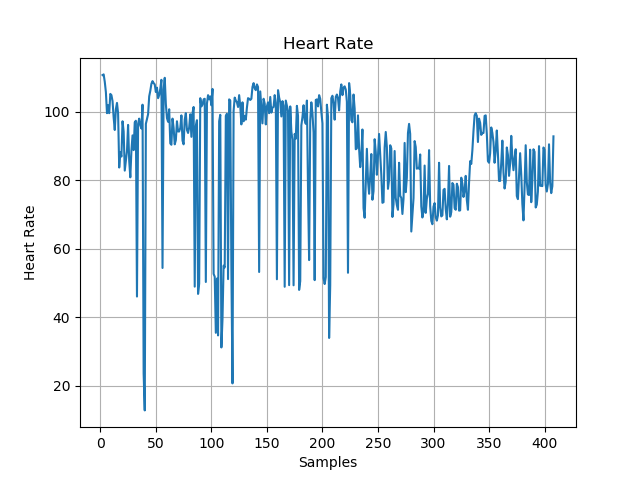

In [9]:
heart_rate = 60/time_duration
plt.figure(3)
plt.plot(sample_axis[1:len(heart_rate)+1],heart_rate)
plt.xlabel('Samples')
plt.ylabel('Heart Rate')
plt.title('Heart Rate')
plt.grid(True)
plt.show()